# Physics-Informed Kolmogorov-Arnold Network (PI-KANs) in Neuromancer

This tutorial demonstrates the use of [PINNs](https://en.wikipedia.org/wiki/Physics-informed_neural_networks) for solving partial differential equations (PDEs) in the Neuromancer library using [KANs](https://arxiv.org/abs/2404.19756).

<img src="../figs/KAN_PINN_diagram.png" width="800">  


Based on the Kolmogorov-Arnold representation theorem, KANs offer an alternative architecture: where traditional neural networks utilize fixed activation functions, KANs employ learnable activation functions on the edges of the network, replacing linear weight parameters with parametrized spline functions. This fundamental shift sometimes enhances model interpretability and improves computational efficiency and accuracy [1]. KANs are available on Neuromancer via `blocks.KANBlock`, which leverages the efficient-kan implementation of [2].

In the example below, we demonstrate how to leverage KANs in a classical fluid dynamics problem: the lid-driven cavity flow. This is a challenging problem for multi-layer perceptron-based PINNs, and while KANs also seem to struggle with this example, we show that it is possible to approximate the solution using a relatively small network, when compared with MLPs.

### References

[1] [Liu, Ziming, et al. (2024). KAN: Kolmogorov-Arnold Networks.](https://arxiv.org/abs/2404.19756)

[2] https://github.com/Blealtan/efficient-kan

[3] [Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations.](https://www.sciencedirect.com/science/article/abs/pii/S0021999118307125)

[4] https://github.com/jdtoscano94/Learning-Python-Physics-Informed-Machine-Learning-PINNs-DeepONets/tree/main

[5] https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main

[6] [Ghia, U. K. N. G., Ghia, K. N., & Shin, C. T. (1982). High-Re solutions for incompressible flow using the Navier-Stokes equations and a multigrid method. Journal of computational physics, 48(3), 387-411.](https://www.sciencedirect.com/science/article/pii/0021999182900584)


## Install (Colab only)
Skip this step when running locally.

In [1]:
# !pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
# !pip install pyDOE

## Imports

In [88]:
import torch
import torch.nn as nn
import numpy as np
# data imports
from scipy.io import loadmat
# plotting imports
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# aux imports
from time import time

# filter some user warnings from torch broadcast
import warnings
warnings.filterwarnings("ignore")


In [2]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cpu')


## Problem Setup

**The [lid-driven cavity flow](https://www.cfd-online.com/Wiki/Lid-driven_cavity_problem)** is a classic benchmark problem in fluid dynamics, where the incompressible Navier-Stokes equations are solved in a squared domain under Dirichlet boundary conditions. The problem, in its dimensionless form, is governed by the momentum and continuity equations:

$$\frac{\partial \boldsymbol{v}^*}{\partial t} + \boldsymbol{v}^* \cdot \nabla^* \boldsymbol{v}^* = - \nabla^* P^* + \frac{1}{Re} \nabla^2 \boldsymbol{v}^*,$$
$$\nabla^* \cdot \boldsymbol{v}^* = 0,$$

where $Re$ denotes the Reynolds number, a dimensionless number that quantifies the ratio between inertial (advective) and viscous (diffusive) effects, and $P$ is the pressure field.

We will assume a two-dimensional space, the fluid velocity $\boldsymbol{v}^*$ and position $\boldsymbol{x}^*$ fields are vectors with components $\boldsymbol{v}^* = [v_x^*, v_y^*]^T$ and $\boldsymbol{x}^* = [x^*, y^*]^T$, with

$$x, y \in [0, 1],$$
$$t \in \mathcal{R},$$

and, for simplicity, we assume steady-state, $\frac{\partial \boldsymbol{v}^*}{\partial t} = 0$.

**Boundary Conditions:**

$$v_x^*(x, y=1, t) = 1,$$
$$v_x^*(x=0, y, t) = v_y^*(x=0, y, t) = 0,$$
$$v_x^*(x=1, y, t) = v_y^*(x=1, y, t) = 0,$$
$$v_x^*(x, y=0, t) = v_y^*(x, y=0, t) = 0,$$
$$v_y^*(x, y=1, t) = 0.$$

### Sample collocation points

In [3]:
# Define number of collocation points in x and y
Nx = 50
Ny = 50

x = torch.linspace(0, 1, Nx)
y = torch.linspace(0, 1, Ny)

X,Y = torch.meshgrid(x,y, indexing="ij")

# Define Reynolds number
Re = 100.

### Test data: PDE solution

In [4]:
# Reshape tensors to 2D 
X_test = X.reshape(-1,1)
Y_test = Y.reshape(-1,1)

###  Construct training datasets

We construct training and development datasets containing [collocation points (CP)](https://en.wikipedia.org/wiki/Collocation_method) of the spatio-temporal domain (x,t), and samples of the [boundary conditions (BC)](https://en.wikipedia.org/wiki/Boundary_value_problem).

The dataset is given as:
$\Xi_{\text{train/test}} = [\texttt{CP}^i, \texttt{BC}^j]$, $i = 1,...,N_{cp}$, $j = 1,...,N_{bc}$  
Where $N_cp$ defines number of collocation points, and $N_{bc}$ number of boundary condition samples.

### Initialize the generalized coordinate fields

In [5]:
## Define a generalized coordinate tensor U = [v1, v2, P]

# Top of lid-driven cavity
ic_U = torch.zeros(size=(Nx,Ny,3)) * 0.
ic_U[:, -1, 0] = 1. # setting v1 = 1 (lid)

print(ic_U.shape)

torch.Size([50, 50, 3])


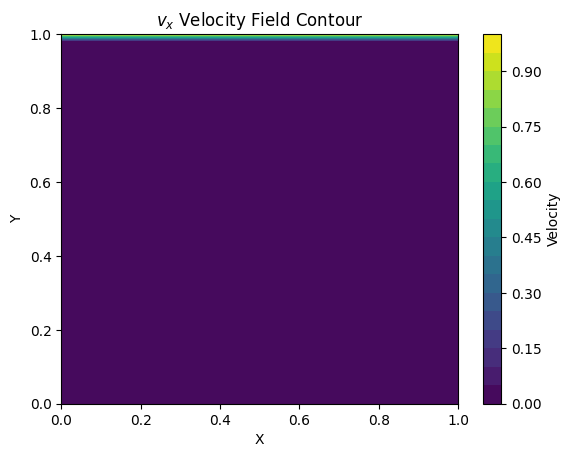

In [97]:
# Plot boundary conditions
plt.figure()
CP = plt.contourf(X, Y, ic_U[:,:,0], levels=20, cmap='viridis')
plt.title('$v_x$ Velocity Field Contour')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(CP, label='Velocity')
plt.show()


### Samples of boundary conditions (BC)

In [98]:
# Left boundary conditions
left_bc_X   = X[[0], :]
left_bc_Y   = Y[[0], :]
left_bc_vx  = ic_U[[0], :, 0]
left_bc_vy  = ic_U[[0], :, 1]
left_bc_p   = ic_U[[0], :, 2]

# Right boundary conditions
right_bc_X  = X[[-1], :]
right_bc_Y  = Y[[-1], :]
right_bc_vx  = ic_U[[-1], :, 0]
right_bc_vy  = ic_U[[-1], :, 1]
right_bc_p   = ic_U[[-1], :, 2]

# Top boundary conditions
top_bc_X  = X[:, [-1]]
top_bc_Y  = Y[:, [-1]]
top_bc_vx  = ic_U[:, [-1], 0]
top_bc_vy  = ic_U[:, [-1], 1]
top_bc_p   = ic_U[:, [-1], 2]

# Bottom boundary conditions
bottom_bc_X   = X[:, [0]]
bottom_bc_Y   = Y[:, [0]]
bottom_bc_vx  = ic_U[:, [0], 0]
bottom_bc_vy  = ic_U[:, [0], 1]
bottom_bc_p   = ic_U[:, [0], 2]


### Number of training samples for BC

In [99]:
print(left_bc_X.shape)
print(right_bc_X.shape)
print(top_bc_X.shape)
print(bottom_bc_X.shape)

print(left_bc_vx.shape)
print(right_bc_vx.shape)
print(top_bc_vx.shape)
print(bottom_bc_vx.shape)

torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([50, 1])
torch.Size([50, 1])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([50, 1])
torch.Size([50, 1])


In [100]:
X_train_bc  = torch.concat([left_bc_X.flatten(), right_bc_X.flatten(), top_bc_X.flatten(), bottom_bc_X.flatten()]).view((-1,1))
Y_train_bc  = torch.concat([left_bc_Y.flatten(), right_bc_Y.flatten(), top_bc_Y.flatten(), bottom_bc_Y.flatten()]).view((-1,1))
vx_train_bc = torch.concat([left_bc_vx.flatten(), right_bc_vx.flatten(), top_bc_vx.flatten(), bottom_bc_vx.flatten()]).view((-1,1))
vy_train_bc = torch.concat([left_bc_vy.flatten(), right_bc_vy.flatten(), top_bc_vy.flatten(), bottom_bc_vy.flatten()]).view((-1,1))
p_train_bc  = torch.concat([left_bc_p.flatten(), right_bc_p.flatten(), top_bc_p.flatten(), bottom_bc_p.flatten()]).view((-1,1))

print(X_train_bc.shape, Y_train_bc.shape, vx_train_bc.shape)

N_bc = X_train_bc.shape[0]

torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 1])


### Samples of collocation points (CP)

In [105]:
# Domain bounds
x_lb = X_test[0]
x_ub = X_test[-1]
y_lb = Y_test[0]
y_ub = Y_test[-1]
print(x_lb, x_ub, y_lb, y_ub)

# Choose (N_collocation) collocation Points to Evaluate the PDE
N_cp = 1000
print(f'Number of collocation points for training: {N_cp}')

# Generate collocation points (CP)
X_train_cp = torch.FloatTensor(N_cp, 1).uniform_(float(x_lb), float(x_ub))
Y_train_cp = torch.FloatTensor(N_cp, 1).uniform_(float(y_lb), float(y_ub))

# Append collocation points and boundary points for training
X_train = torch.vstack((X_train_cp, X_train_bc)).float()
Y_train = torch.vstack((Y_train_cp, Y_train_bc)).float()
print(X_train.shape, Y_train.shape)

tensor([0.]) tensor([1.]) tensor([0.]) tensor([1.])
Number of collocation points for training: 1000
torch.Size([1200, 1]) torch.Size([1200, 1])


### Plot collocation points

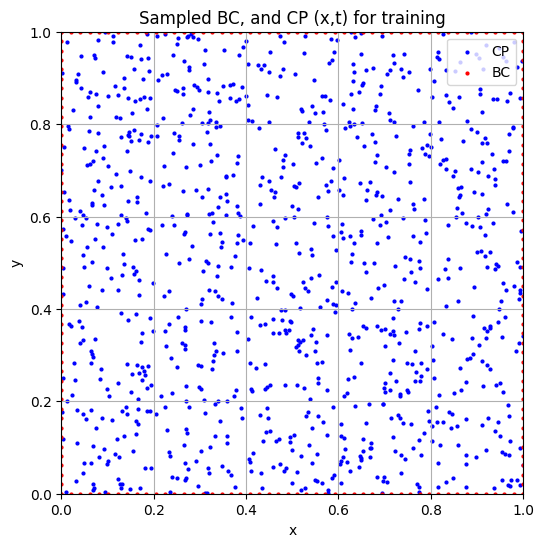

In [106]:
# Create a figure and axis object
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Scatter plot for CP points
ax.scatter(X_train_cp.detach().cpu().numpy(), Y_train_cp.detach().cpu().numpy(),
           s=4., c='blue', marker='o', label='CP')
# Scatter plot for BC points

ax.scatter(X_train_bc.detach().cpu().numpy(), Y_train_bc.detach().cpu().numpy(),
           s=4., c='red', marker='o', label='BC')

ax.set_title('Sampled BC, and CP (x,t) for training')
ax.set_xlim(x_lb, x_ub)
ax.set_ylim(y_lb, y_ub)
ax.grid(True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='upper right')
ax.set_aspect('equal', 'box')
plt.show()


### Create Neuromancer datasets

In [107]:
from neuromancer.dataset import DictDataset

# turn on gradients for PINN
X_train.requires_grad=True
Y_train.requires_grad=True

# Training dataset
train_data = DictDataset({'x': X_train, 'y':Y_train}, name='train')
# test dataset
test_data = DictDataset({'x': X_test, 'y':Y_test}, name='test')

# torch dataloaders
batch_size = X_train.shape[0]  # full batch training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         collate_fn=test_data.collate_fn,
                                         shuffle=False)

## Network architecture

We will use a neural network to approximate the PDE solutions:

$$\{ \hat{v_x^*}, \hat{v_y^*}, \hat{p^*} \} \approx NN_{\theta}(x^*, y^*) = \boldsymbol{U}^*_\theta,$$

where $\hat{v_x^*}, \hat{v_y^*}, \hat{p^*}$ denote the approximate velocity and pressure fields.

First, we instantiate a `KANBlock`. We use the following configurations:

- **`insize`**: *(int)* – The size of the input features for each KAN layer in the block. In this case, since the input $(x,y)$ is 2D, `insize=2`.

- **`outsize`**: *(int)* – The size of the output features for each KAN layer in the block. Since we have 3 outputs (velocities $v_x, v_y$ and pressure $p$), the output is set to `outsize=3`.

- **`hsizes`**: *(list[int])* – A list defining the size of each hidden layer. For example, `hsizes=[5]` creates a single hidden layer with 5 neurons.

- **`spline_order`**: *(int)* – Specifies the order of the B-spline basis functions. Higher orders allow for more expressivity, as it increases the number of trainable parameters.


In [108]:
from neuromancer.modules import blocks
from neuromancer.system import Node, System

# neural net to solve the PDE problem
net = blocks.KANBlock(insize=2,
                      outsize=3,
                      hsizes=[5,5],
                      spline_order=5)

# symbolic wrapper of the neural net
pde_net = Node(net, ['x', 'y'], ['U'], name='net')

In [109]:
print("symbolic inputs  of the pde_net:", pde_net.input_keys)
print("symbolic outputs of the pde_net:", pde_net.output_keys)

symbolic inputs  of the pde_net: ['x', 'y']
symbolic outputs of the pde_net: ['U']


In [110]:
pde_net(train_data.datadict)

{'U': tensor([[ 0.0556, -0.0247,  0.0546],
         [ 0.0629, -0.0222,  0.0615],
         [ 0.0373, -0.0213,  0.0362],
         ...,
         [ 0.0772, -0.0224,  0.0759],
         [ 0.0790, -0.0228,  0.0778],
         [ 0.0807, -0.0232,  0.0797]], grad_fn=<SqueezeBackward1>)}

In [111]:
# forward pass
net_out = pde_net(train_data.datadict)
print(pde_net(train_data.datadict).keys())
print(pde_net(train_data.datadict)['U'].shape)

dict_keys(['U'])
torch.Size([1200, 3])


###  Define physics-informed terms

Our neural network approximation  must satisfy the PDE equations  $NN_{\theta}(x,y) \approx [v_x^*, v_y^*, P^*]^T$.
Thus we define the physics-informed layers as $f_{\texttt{PINN}} = [f_{\texttt{PINN}_1}, f_{\texttt{PINN}_2}, f_{\texttt{PINN}_3}]^T$:

$$[f_{\texttt{PINN}_1}, f_{\texttt{PINN}_2}]^T =
\boldsymbol{v}^* \cdot \nabla^* \boldsymbol{v}^* +\nabla^* P^* - \frac{1}{Re} \nabla^2 \boldsymbol{v}^*, $$ 
$$f_{\texttt{PINN}_3} = \nabla^* \cdot \boldsymbol{v}^* = 0. $$

We can obtain the derivatives of the neural net $\frac{\partial NN_{\theta}}{\partial x}$, $\frac{\partial NN_{\theta}}{\partial y}$ $\frac{\partial^2 NN_{\theta}}{\partial x^2}$, $\frac{\partial^2 NN_{\theta}}{\partial y^2}$ using [Automatic Diferentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).

To simplify the implementation of $f_{\texttt{PINN}}$ we exploit the symbolic variable of the Neuromancer library.

In [112]:
from neuromancer.constraint import variable

# symbolic Neuromancer variables
U = variable('U')
vx = variable('U')[:,[0]]
vy = variable('U')[:,[1]]
p = variable('U')[:,[2]]
x = variable('x')  # spatial coordinate 1
y = variable('y')  # spatial coordinate 2

In [113]:
# get the symbolic derivatives
dvx_dx   = vx.grad(x)
dvy_dx   = vy.grad(x)
dp_dx    = p.grad(x)

dvx_dy   = vx.grad(y)
dvy_dy   = vy.grad(y)
dp_dy    = p.grad(y)

d2vx_dx2 = dvx_dx.grad(x)
d2vy_dx2 = dvy_dx.grad(x)
d2vx_dy2 = dvx_dy.grad(y)
d2vy_dy2 = dvy_dy.grad(y)
    
# get the PINN form
f_pinn_1 = (1./Re)*(d2vx_dx2 + d2vx_dy2) - vx * dvx_dx - vy * dvx_dy - dp_dx
f_pinn_2 = (1./Re)* (d2vy_dx2 + d2vy_dy2) - vy * dvy_dx - vy * dvy_dy - dp_dy 
f_pinn_3 = dvx_dx + dvy_dy


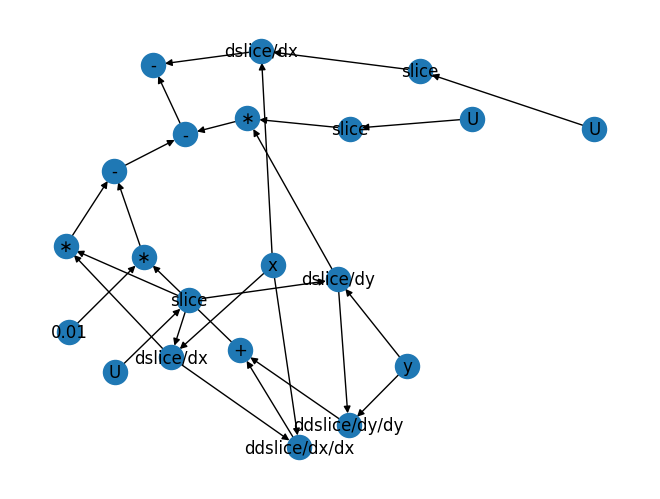

In [114]:
f_pinn_1.show()

In [115]:
# check the shapes of the forward pass of the symbolic PINN terms
print(f"vx: {vx({**net_out, **train_data.datadict}).shape}")
print(f"vy: {vy({**net_out, **train_data.datadict}).shape}")
print(f"p: {p({**net_out, **train_data.datadict}).shape}")

print(f"dvx_dx: {dvx_dx({**net_out, **train_data.datadict}).shape}")
print(f"dvy_dx: {dvy_dx({**net_out, **train_data.datadict}).shape}")
print(f"dp_dx: {dp_dx({**net_out, **train_data.datadict}).shape}")

print(f"dvx_dy: {dvx_dy({**net_out, **train_data.datadict}).shape}")
print(f"dvy_dy: {dvy_dy({**net_out, **train_data.datadict}).shape}")
print(f"dp_dy: {dp_dy({**net_out, **train_data.datadict}).shape}")

print(f"d2vx_dx2: {d2vx_dx2({**net_out, **train_data.datadict}).shape}")
print(f"d2vy_dx2: {d2vy_dx2({**net_out, **train_data.datadict}).shape}")
print(f"d2vx_dy2: {d2vx_dy2({**net_out, **train_data.datadict}).shape}")
print(f"d2vy_dy2: {d2vy_dy2({**net_out, **train_data.datadict}).shape}")

print(f"f_pinn_1: {f_pinn_1({**net_out, **train_data.datadict}).shape}")
print(f"f_pinn_2: {f_pinn_2({**net_out, **train_data.datadict}).shape}")
print(f"f_pinn_3: {f_pinn_3({**net_out, **train_data.datadict}).shape}")


vx: torch.Size([1200, 1])
vy: torch.Size([1200, 1])
p: torch.Size([1200, 1])
dvx_dx: torch.Size([1200, 1])
dvy_dx: torch.Size([1200, 1])
dp_dx: torch.Size([1200, 1])
dvx_dy: torch.Size([1200, 1])
dvy_dy: torch.Size([1200, 1])
dp_dy: torch.Size([1200, 1])
d2vx_dx2: torch.Size([1200, 1])
d2vy_dx2: torch.Size([1200, 1])
d2vx_dy2: torch.Size([1200, 1])
d2vy_dy2: torch.Size([1200, 1])
f_pinn_1: torch.Size([1200, 1])
f_pinn_2: torch.Size([1200, 1])
f_pinn_3: torch.Size([1200, 1])


### PINNs' loss function terms

**PDE collocation points loss:**  
We evaluate our PINN $f_{\texttt{PINN}}$ over a given number ($N_{cp}$) of collocation points (CP) and minimize the PDE residuals using the following loss function:

$$
\ell_{cp} = \frac{1}{N_{cp}} \sum^{N_{cp}}_{i=1} |f_{\texttt{PINN}}(x_{cp}^i, y_{cp}^i)|^2
$$

If $f_{\texttt{PINN}} \rightarrow 0$, then our PINN will respect the physical law.

**PDE initial and boundary conditions loss:**

We select $N_{bc}$ points from our BC and use them in the following supervised learning loss function:

$$
\ell_{bc} = \frac{1}{N_{bc}} \sum^{N_{bc}}_{i=1} \left( |v_x(x_{bc}^i, y_{bc}^i) - NN_{\theta}^{v_x}(x_{bc}^i, y_{bc}^i)|^2 + |v_y(x_{bc}^i, y_{bc}^i) - NN_{\theta}^{v_y}(x_{bc}^i, y_{bc}^i)|^2 + |P(x_{bc}^i, y_{bc}^i) - NN_{\theta}^{P}(x_{bc}^i, y_{bc}^i)|^2 \right)
$$

#### Total loss:
The total loss is a weighted sum of PDE residuals over CP and supervised learning residuals over BC.

$$
\ell_{\text{PINN}} = \omega_{cp} \ell_{cp} + \omega_{bc} \ell_{bc}
$$

with scaling weights $\omega_{cp}$ and $\omega_{bc}$.


In [116]:
# scaling factor for better convergence
scaling_cp = 1.
scaling_bc = 1.
scaling_continuity = 1.

# PDE CP loss (MSE)
l_cp_1 = scaling_cp*(f_pinn_1 == 0.)^2
l_cp_2 = scaling_cp*(f_pinn_2 == 0.)^2
l_cp_3 = scaling_continuity*(f_pinn_3 == 0.)^2
l_cp_1.update_name("loss_cp_1")
l_cp_2.update_name("loss_cp_2")
l_cp_3.update_name("loss_cp_3")

# PDE BC loss (MSE)
# note: remember that we concatenated CP and BC
l_bc_1 = scaling_bc*( vx[-N_bc:] == vx_train_bc)^2
l_bc_2 = scaling_bc*( vy[-N_bc:] == vy_train_bc)^2
l_bc_3 = scaling_bc*( p[-N_bc:] == p_train_bc)^2

l_bc_1.update_name("loss_bc_1")
l_bc_2.update_name("loss_bc_2")
l_bc_3.update_name("loss_bc_3")


##  Train the network to solve the PDE

We use stochastic gradient descent to optimize the parameters $\theta$ of the neural network $NN_{\theta}$ approximating the solution to the PDE equation using the PINN loss $\ell_{\text{PINN}}$ evaluated over sampled CP and BC.

### Define the optimization problem in Neuromancer

In [117]:
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem

# Import PenaltyLoss
pinn_loss = PenaltyLoss(objectives=[l_cp_1, l_cp_2, l_cp_3, l_bc_1, l_bc_2, l_bc_3], constraints=[])

# construct the PINN optimization problem
problem = Problem(nodes=[pde_net],      # list of nodes (neural nets) to be optimized
                  loss=pinn_loss,       # physics-informed loss function
                  grad_inference=True   # argument for allowing computation of gradients at the inference time
                 )

### Construct trainer and solve the problem  

In [118]:
from neuromancer.trainer import Trainer

optimizer = torch.optim.AdamW(problem.parameters(), lr=1e-2)
epochs = 5000

#  Neuromancer trainer
trainer = Trainer(
    problem.to(device),
    train_loader,
    optimizer=optimizer,
    epochs=epochs,
    epoch_verbose=500,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup=epochs,
    device=device
)

In [119]:
# Train PINN
t0 = time()
best_model = trainer.train()
print(f"Elapsed time: {time()-t0} s")

# load best trained model
problem.load_state_dict(best_model)

epoch: 0  train_loss: 0.2642546594142914
epoch: 500  train_loss: 0.012574609369039536
epoch: 1000  train_loss: 0.010700698010623455
epoch: 1500  train_loss: 0.009670949541032314
epoch: 2000  train_loss: 0.0111280782148242
epoch: 2500  train_loss: 0.008988277986645699
epoch: 3000  train_loss: 0.008811574429273605
epoch: 3500  train_loss: 0.008660368621349335
epoch: 4000  train_loss: 0.008946198970079422
epoch: 4500  train_loss: 0.008528809994459152
Elapsed time: 742.4486649036407 s


<All keys matched successfully>

## Results

In this section, we use the trained physics-informed KAN to predict the fields $v_x, v_y$ and $p$ and analyze the results.

In [123]:
# Evaluate trained PINN on test data (all the data in the domain)
PINN = problem.nodes[0]
U_pinn = PINN(test_data.datadict)['U']

# arrange data for plotting
vx_pinn = U_pinn[:,0].reshape(shape=[Nx,Ny]).detach().cpu()
vy_pinn = U_pinn[:,1].reshape(shape=[Nx,Ny]).detach().cpu()
p_pinn = U_pinn[:,2].reshape(shape=[Nx,Ny]).detach().cpu()


### Plot 1: contour plots of velocities and pressure

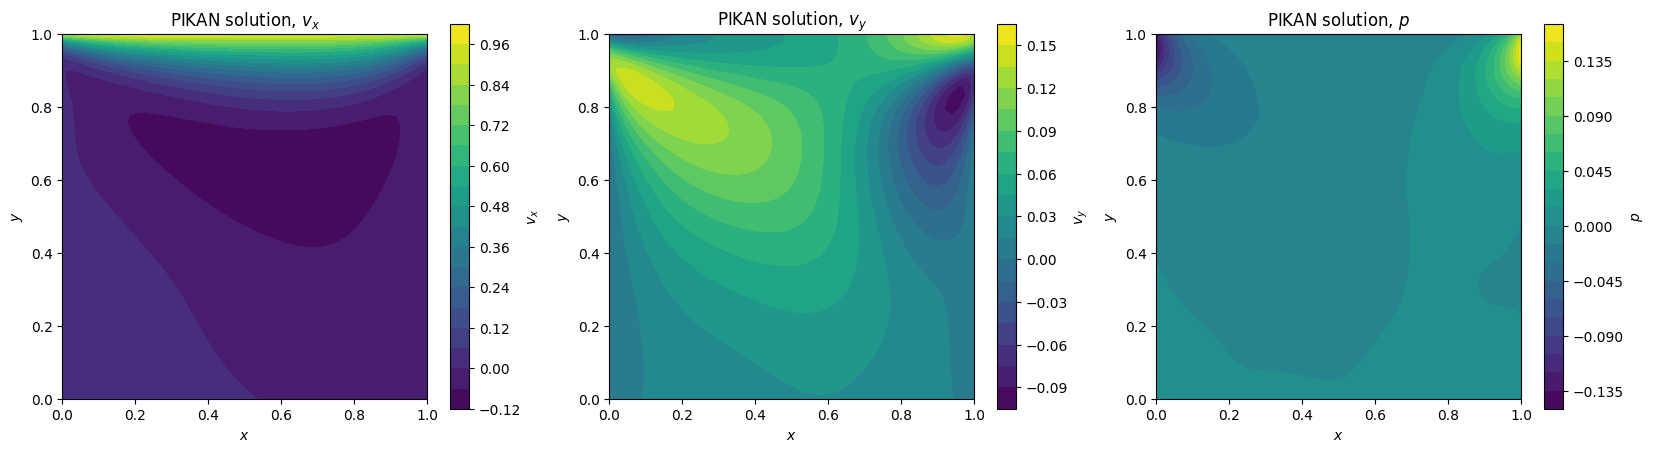

In [124]:
# plot PINN solution
plt.figure(figsize=(20, 5))

# # Plot for the second heatmap (PINN solution)
ax2 = plt.subplot(1, 3, 1)
CP2 = plt.contourf(X, Y, vx_pinn, levels=20, cmap='viridis')
plt.title('PIKAN solution, $v_x$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(CP2, label='$v_x$')
ax2.set_aspect('equal', adjustable='box')

ax2 = plt.subplot(1, 3, 2)
CP2 = plt.contourf(X, Y, vy_pinn, levels=20, cmap='viridis')
plt.title('PIKAN solution, $v_y$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(CP2, label='$v_y$')
ax2.set_aspect('equal', adjustable='box')

ax2 = plt.subplot(1, 3, 3)
CP2 = plt.contourf(X, Y, p_pinn, levels=20, cmap='viridis')
plt.title('PIKAN solution, $p$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(CP2, label='$p$')
ax2.set_aspect('equal', adjustable='box')


### Plot 2: contour plots of the velocity magnitude and streamlines

On the left figure, we plot the velocity magnitude, $ |\boldsymbol{v}| $, given by:

$$
|\boldsymbol{v}| = \sqrt{v_x^2 + v_y^2}.
$$


On the right figure, we show the streamlines for the lid-driven cavity flow. The streamlines illustrate the circulating flow pattern generated by the moving lid, with a primary vortex forming at the center of the cavity. The position of the central vortex indicates that the PIKAN could possibly benefit from longer training. Try increasing the number of epochs and see the difference!

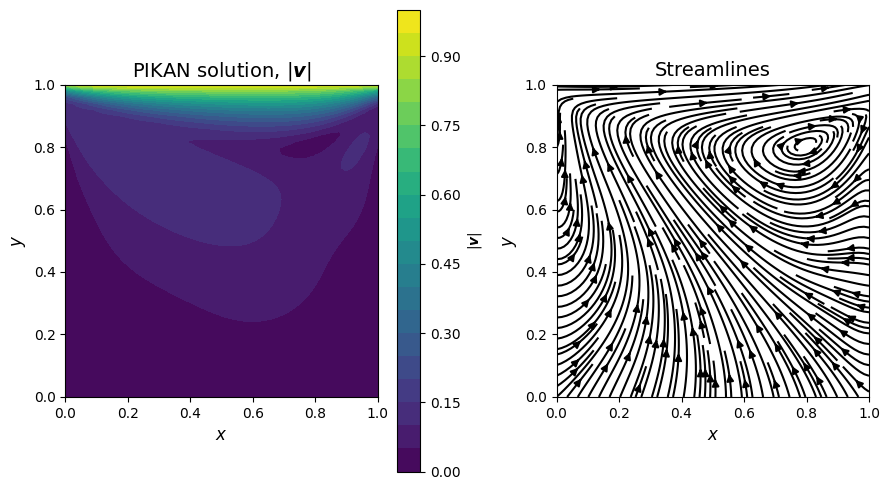

In [130]:
# Plot
fig = plt.figure(figsize=(9, 5))
gs = GridSpec(1, 2, width_ratios=[1, 0.8], height_ratios=[1])

# Left plot: PINN solution with velocity magnitude
ax1 = fig.add_subplot(gs[0, 0])
CP1 = ax1.contourf(X, Y, np.sqrt(vx_pinn**2 + vy_pinn**2), levels=20, cmap='viridis')
ax1.set_title('PIKAN solution, $|\\boldsymbol{v}|$', fontsize=14)
ax1.set_xlabel('$x$', fontsize=12)
ax1.set_ylabel('$y$', fontsize=12)
plt.colorbar(CP1, ax=ax1, label='$|\\boldsymbol{v}|$')
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim(0., 1.)
ax1.set_ylim(0., 1.)

# Right plot: Streamlines without magnitude colorbar
ax2 = fig.add_subplot(gs[0, 1])
x_ = np.linspace(0, 1, Nx)
y_ = np.linspace(0, 1, Ny)
strm = ax2.streamplot(x_, y_, vx_pinn.T, vy_pinn.T, color='k', density=2, minlength=0.1)
ax2.set_title('Streamlines', fontsize=14)
ax2.set_xlabel('$x$', fontsize=12)
ax2.set_ylabel('$y$', fontsize=12)
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(0., 1.)
ax2.set_ylim(0., 1.)

# Apply tight layout for even spacing
plt.tight_layout()
plt.show()

### Centerline velocity comparisons

This plot shows the comparison of centerline velocities for the lid-driven cavity flow against the benchmark computational fluid dynamics (CFD) results of Ghia et al. (1982) [6]. In this analysis, velocity profiles are extracted along the vertical and horizontal centerlines of the cavity, capturing the variation of velocity across these lines. Comparing these profiles helps validate the accuracy of the simulation, as their data is widely recognized as a benchmark for lid-driven cavity flow. 

Notice how $v_y$ is not looking as good as $v_x$. That typically indicates that the PIKAN hasn't fully converged. Try experimenting with slightly larger hidden network sizes, such as hsizes=[8,8], or increasing the number of collocation points. 

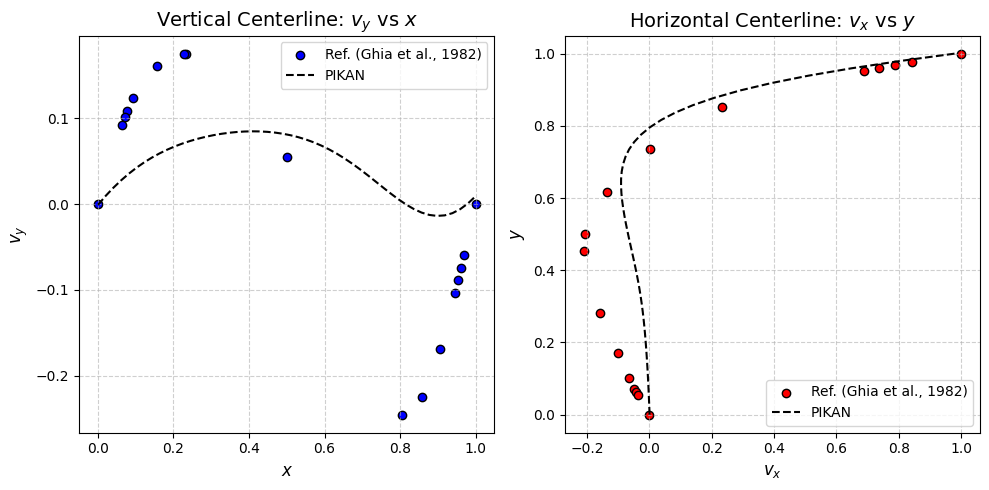

In [129]:
# Get centerline solutions
x_ = test_data.datadict['x'].reshape(Nx,Ny).cpu()
y_ = test_data.datadict['y'].reshape(Nx,Ny).cpu()
eval_solution_pinn = PINN(test_data.datadict)['U'].reshape(Nx,Ny,-1)
vx_est = eval_solution_pinn[:,:,0].cpu().detach().numpy()
vy_est = eval_solution_pinn[:,:,1].cpu().detach().numpy()

# Reference velocities (Ghia et al., 1982)
ref_x = torch.tensor([1.00000,0.9688,0.9609,0.9531,0.9453,0.9063,0.8594,0.8047,0.5000,0.2344,0.2266,0.1563,0.0938,0.0781,0.0703,0.0625,0.0000])
ref_y = torch.tensor([1.0000,0.9766,0.9688,0.9609,0.9531,0.8516,0.7344,0.6172,0.5000,0.4531,0.2813,0.1719,0.1016,0.0703,0.0625,0.0547,0.0000])
ref_vx_Re100 = torch.tensor([1.00000,0.84123,0.78871,0.73722,0.68717,0.23151,0.00332,-0.13641,-0.20581,-0.21090,-0.15662,-0.10150,-0.06434,-0.04775,-0.04192,-0.03717,0.00000])
ref_vy_Re100 = torch.tensor([0.00000,-0.05906,-0.07391,-0.08864,-0.10313,-0.16914,-0.22445,-0.24533,0.05454,0.17527,0.17507,0.16077,0.12317,0.10890,0.10091,0.09233,0.00000])

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

# x vs vy - Plotting vertical centerline comparison
ax[0].scatter(ref_x, ref_vy_Re100, color='blue', marker='o', edgecolor='black', label='Ref. (Ghia et al., 1982)')
ax[0].plot(x_[:, Nx // 2], vy_est[:, Ny // 2], color='black', linestyle='--', linewidth=1.5, label='PIKAN')
ax[0].set_xlabel('$x$', fontsize=12)
ax[0].set_ylabel('$v_y$', fontsize=12)
ax[0].set_title("Vertical Centerline: $v_y$ vs $x$", fontsize=14)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].legend()

# vx vs y - Plotting horizontal centerline comparison
ax[1].scatter(ref_vx_Re100, ref_y, color='red', marker='o', edgecolor='black', label='Ref. (Ghia et al., 1982)')
ax[1].plot(vx_est[Nx // 2, :], y_[Nx // 2, :], color='black', linestyle='--', linewidth=1.5, label='PIKAN')
ax[1].set_xlabel('$v_x$', fontsize=12)
ax[1].set_ylabel('$y$', fontsize=12)
ax[1].set_title("Horizontal Centerline: $v_x$ vs $y$", fontsize=14)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].legend()

plt.tight_layout()
plt.show()
